<a href="https://colab.research.google.com/github/LelyshB/parsing_and_clearing_Wildberiess/blob/main/parsing_and_clearing_Wildberiess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Парсим данные с wildberries**


In [2]:
pip install retry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 3.3 MB/s eta 0:00:00


In [3]:
import datetime
import requests
import pandas as pd
from retry import retry


HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0",
    "Accept": "*/*",
    "Accept-Language": "ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3",
    "Accept-Encoding": "gzip, deflate, br",
    "Origin": "https://www.wildberries.ru",
    'Content-Type': 'application/json; charset=utf-8',
    'Transfer-Encoding': 'chunked',
    "Connection": "keep-alive",
    'Vary': 'Accept-Encoding',
    'Content-Encoding': 'gzip',
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "cross-site"
}
CATALOG_URL = 'https://static-basket-01.wbbasket.ru/vol0/data/main-menu-ru-ru-v2.json'


def get_catalogs_wb() -> dict:
    """получаем полный каталог Wildberries"""
    return requests.get(CATALOG_URL, headers=HEADERS).json()


def get_data_category(catalogs_wb: dict) -> list:
    """сбор данных категорий из каталога Wildberries"""
    catalog_data = []
    if isinstance(catalogs_wb, dict) and 'childs' not in catalogs_wb:
        catalog_data.append({
            'name': f"{catalogs_wb['name']}",
            'shard': catalogs_wb.get('shard', None),
            'url': catalogs_wb['url'],
            'query': catalogs_wb.get('query', None)
        })
    elif isinstance(catalogs_wb, dict):
        catalog_data.extend(get_data_category(catalogs_wb['childs']))
    else:
        for child in catalogs_wb:
            catalog_data.extend(get_data_category(child))
    return catalog_data


def search_category_in_catalog(url: str, catalog_list: list) -> dict:
    """проверка пользовательской ссылки на наличии в каталоге"""
    for catalog in catalog_list:
        if catalog['url'] == url.split('https://www.wildberries.ru')[-1]:
            print(f'найдено совпадение: {catalog["name"]}')
            return catalog


def get_data_from_json(json_file: dict) -> list:
    """извлекаем из json данные"""
    data_list = []
    for data in json_file['data']['products']:
        data_list.append({
            'id': data.get('id'),
            'Наименование': data.get('name'),
            'Цена': int(data.get("priceU") / 100),
            'Цена со скидкой': int(data.get('salePriceU') / 100),
            'Скидка': data.get('sale'),
            'Бренд': data.get('brand'),
            'Рейтинг': data.get('rating'),
            'Продавец': data.get('supplier'),
            'Рейтинг продавца': data.get('supplierRating'),
            'Кол-во отзывов': data.get('feedbacks'),
            'Рейтинг отзывов': data.get('reviewRating'),
            'Промо текст карточки': data.get('promoTextCard'),
            'Промо текст категории': data.get('promoTextCat'),
            'Ссылка': f'https://www.wildberries.ru/catalog/{data.get("id")}/detail.aspx?targetUrl=BP'
        })
    return data_list


@retry(Exception, tries=-1, delay=0)
def scrap_page(page: int, shard: str, query: str, low_price: int, top_price: int, discount: int = None) -> dict:
    """Сбор данных со страниц"""
    url = f'https://catalog.wb.ru/catalog/{shard}/catalog?appType=1&curr=rub' \
          f'&dest=-1257786' \
          f'&locale=ru' \
          f'&page={page}' \
          f'&priceU={low_price * 100};{top_price * 100}' \
          f'&sort=popular&spp=0' \
          f'&{query}' \
          f'&discount={discount}'

    r = requests.get(url, headers=HEADERS)
    return r.json()


def save_csv(data: list, filename: str):
    """сохранение результата в CSV файл"""
    df = pd.DataFrame(data)
    df.to_csv(f'{filename}.csv', index=False)
    print(f'Все сохранено в {filename}.csv\n')


def parser(url: str, low_price: int = 1, top_price: int = 1000000, discount: int = 0):
    """основная функция"""
    # получаем данные по заданному каталогу
    catalog_data = get_data_category(get_catalogs_wb())

    # поиск введенной категории в общем каталоге
    category = search_category_in_catalog(url=url, catalog_list=catalog_data)
    data_list = []
    for page in range(1, 51):  # вб отдает 50 страниц товара
        data = scrap_page(
            page=page,
            shard=category['shard'],
            query=category['query'],
            low_price=low_price,
            top_price=top_price,
            discount=discount)
        if len(get_data_from_json(data)) > 0:
            data_list.extend(get_data_from_json(data))
        else:
            break
    print(f'Сбор данных завершен. Собрано: {len(data_list)} товаров.')

    # сохранение найденных данных
    save_csv(data_list, f'{category["name"]}_from_{low_price}_to_{top_price}')

if __name__ == '__main__':
    url = 'https://www.wildberries.ru/catalog/elektronika/smartfony-i-telefony/vse-smartfony'
    low_price = 100  # нижний порог цены
    top_price = 100000  # верхний порог цены
    discount = 10  # скидка в %
    start = datetime.datetime.now()  # запишем время старта

    parser(url=url, low_price=low_price, top_price=top_price, discount=discount)

    end = datetime.datetime.now()  # запишем время завершения кода
    total = end - start  # расчитаем время затраченное на выполнение кода
    print("Затраченное время:" + str(total))

найдено совпадение: Смартфоны


Сбор данных завершен. Собрано: 5000 товаров.
Все сохранено в Смартфоны_from_100_to_100000.csv

Затраченное время:0:01:07.689165



# **Приступаем к анализу данных**

# Импорты

In [26]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

plt.style.use('dark_background')

# **EDA**

In [5]:
df = pd.read_csv('/content/Смартфоны_from_100_to_100000.csv')

In [6]:
df.sample(5)

,id,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Промо текст карточки,Промо текст категории,Ссылка
2890,196450444,Смартфон Hot 40i 8 256Gb Starlit Black,12980,10643,18,Infinix,5,TexnikaPro,4.7,22,4.5,NaN,NaN,https://www.wildberries.ru/catalog/196450444/d...
4982,189646491,"Смартфон X5 5G 8 256 ГБ RU, черный",26000,21320,18,Poco,5,Pro-Device,4.9,6,5.0,NaN,NaN,https://www.wildberries.ru/catalog/189646491/d...
1345,200702396,Смартфон Spark Go 2024 4Gb 64Gb белый,7990,6158,22,TECNO,5,ПРОдвижение,4.8,2,5.0,NaN,NaN,https://www.wildberries.ru/catalog/200702396/d...
2007,173822751,Смартфон HOT 30i 128GB+4GB,20316,8496,58,Infinix,0,S.N.M.I.S. Store,4.6,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/173822751/d...
2903,210368425,Смартфон Zero 30 8 256Gb золотой,21990,18031,18,Infinix,5,TexnikaPro,4.7,1,5.0,NaN,NaN,https://www.wildberries.ru/catalog/210368425/d...


In [7]:
df.isna().sum()

id                          0
Наименование                0
Цена                        0
Цена со скидкой             0
Скидка                      0
Бренд                      50
Рейтинг                     0
Продавец                    0
Рейтинг продавца            0
Кол-во отзывов              0
Рейтинг отзывов             0
Промо текст карточки     3181
Промо текст категории    3181
Ссылка                      0
dtype: int64

In [8]:
df.describe()

,id,Цена,Цена со скидкой,Скидка,Рейтинг,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов
count,5.000000e+03,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.967673e+08,30859.425200,20569.237000,31.25340,2.742400,4.56600,96.607600,2.694440
std,2.356200e+07,29256.827916,19669.608299,14.50276,2.308919,0.28333,674.774527,2.265939
min,2.720788e+07,101.000000,101.000000,0.00000,0.000000,3.60000,0.000000,0.000000
25%,1.894629e+08,12868.000000,8711.000000,18.00000,0.000000,4.40000,0.000000,0.000000
50%,2.059264e+08,20042.500000,13120.000000,28.00000,4.000000,4.60000,2.000000,4.000000
75%,2.109370e+08,36990.000000,23579.000000,39.00000,5.000000,4.80000,22.000000,4.900000
max,2.207157e+08,470000.000000,102850.000000,95.00000,5.000000,5.00000,13002.000000,5.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     5000 non-null   int64  
 1   Наименование           5000 non-null   object 
 2   Цена                   5000 non-null   int64  
 3   Цена со скидкой        5000 non-null   int64  
 4   Скидка                 5000 non-null   int64  
 5   Бренд                  4950 non-null   object 
 6   Рейтинг                5000 non-null   int64  
 7   Продавец               5000 non-null   object 
 8   Рейтинг продавца       5000 non-null   float64
 9   Кол-во отзывов         5000 non-null   int64  
 10  Рейтинг отзывов        5000 non-null   float64
 11  Промо текст карточки   1819 non-null   object 
 12  Промо текст категории  1819 non-null   object 
 13  Ссылка                 5000 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 547.0+ 

In [10]:
df = df.drop(['id', 'Ссылка'], axis = 1)


In [11]:
df.sample(5)

,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Промо текст карточки,Промо текст категории
4335,"Смартфон Huawei Y7 Prime 2018 4 128 Гб, черный",7499,5657,24,Honor,3,VASKIM STORE,3.8,4,3.0,NaN,NaN
2679,Смартфон M5s 6 128 ГБ,21500,15514,27,POCO,3,OOO.smart,4.6,8,2.8,ТОП ВЫГОДНО,ТОП ВЫГОДНО
3923,Смартфон Reno 10 Pro 12 512 GB,23396,9016,61,Bobarry,0,Bobarry,3.7,0,0.0,ТОП ВЫГОДНО,ТОП ВЫГОДНО
4332,"Смартфон C55, 8 256 Гб",20990,14630,30,Realme,5,Мобител,4.7,7,4.9,NaN,NaN
1827,Смартфон Xiao Red Note 10 Pro 6 128Gb,19000,14489,23,MI,3,OOO.smart,4.6,12,2.8,NaN,NaN


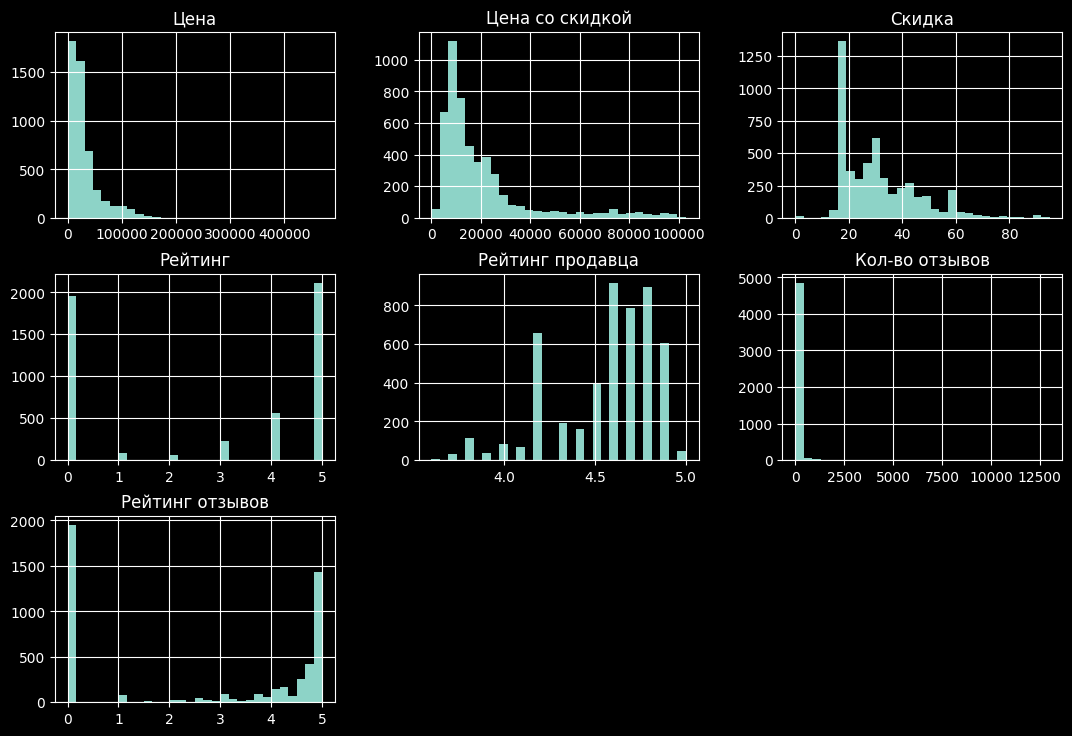

In [12]:
df.hist(bins=30, figsize=(13, 15), layout=(5, 3))
plt.show()

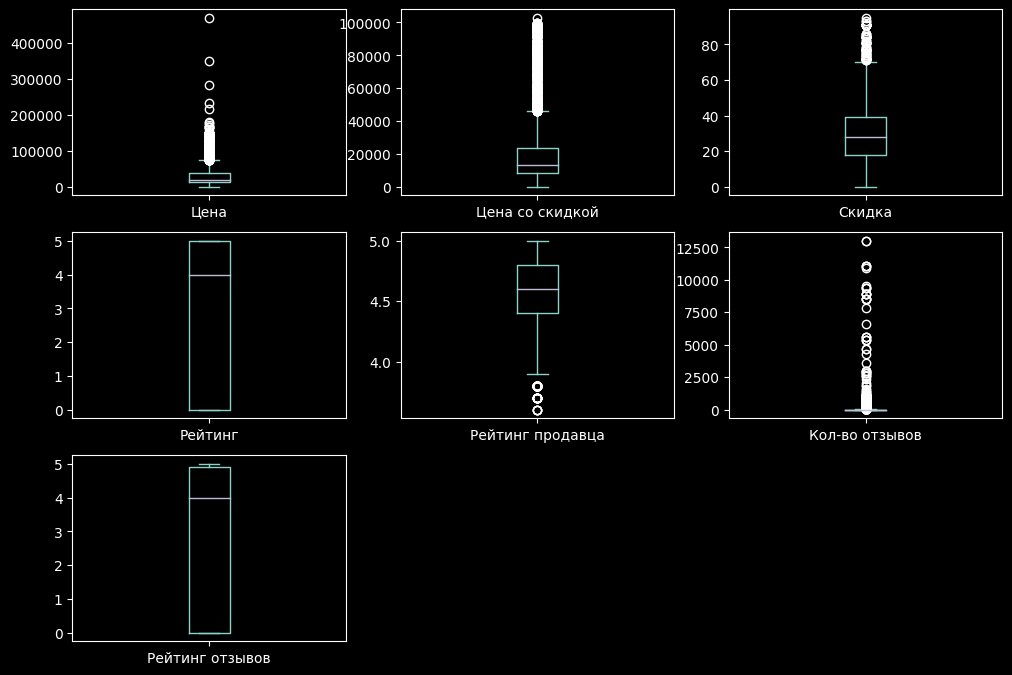

In [13]:
df.plot(kind='box', subplots=True, layout=(5, 3), figsize=(12, 14))
plt.show()

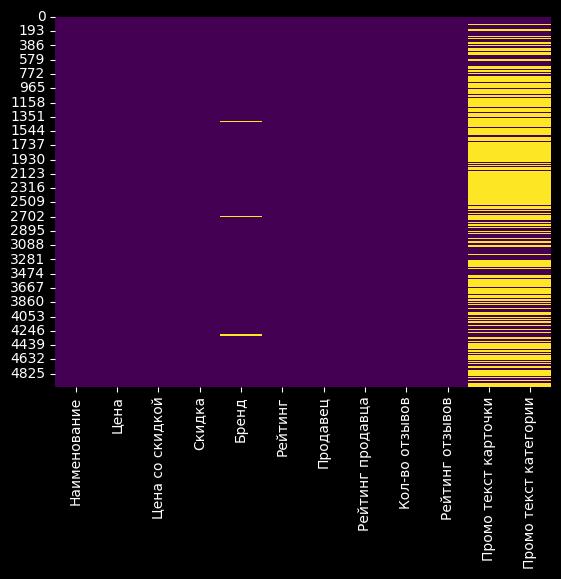

In [14]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

**Из анализа можно понять:**

 * В некоторых переменных присутствуют широкие хвосты

 * У двух переменных отсутствует слишком много значений, поэтому избавляемся от них

Также уберём нули в колонке "Бренд"

In [15]:
df =  df.drop(['Промо текст карточки', 'Промо текст категории'], axis = 1)

In [16]:
df['Бренд']  = df['Бренд'].fillna('nan')

In [17]:
df.isna().sum()

Наименование        0
Цена                0
Цена со скидкой     0
Скидка              0
Бренд               0
Рейтинг             0
Продавец            0
Рейтинг продавца    0
Кол-во отзывов      0
Рейтинг отзывов     0
dtype: int64

In [18]:
df.describe()

,Цена,Цена со скидкой,Скидка,Рейтинг,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000
mean,30859.425200,20569.237000,31.25340,2.742400,4.56600,96.607600,2.694440
std,29256.827916,19669.608299,14.50276,2.308919,0.28333,674.774527,2.265939
min,101.000000,101.000000,0.00000,0.000000,3.60000,0.000000,0.000000
25%,12868.000000,8711.000000,18.00000,0.000000,4.40000,0.000000,0.000000
50%,20042.500000,13120.000000,28.00000,4.000000,4.60000,2.000000,4.000000
75%,36990.000000,23579.000000,39.00000,5.000000,4.80000,22.000000,4.900000
max,470000.000000,102850.000000,95.00000,5.000000,5.00000,13002.000000,5.000000


# **Кластеризация**

Kmean++

**Предварительная обработка данных: удаление нулей, стандартизация, кодирование и создание нового признака**


In [19]:
df['Рейтинг'] = df['Рейтинг'].replace(0, np.nan)
df['Кол-во отзывов'] = df['Кол-во отзывов'].replace(0, np.nan)
df = df.dropna(subset=['Рейтинг', 'Кол-во отзывов'])

numerical_cols = ['Цена', 'Цена со скидкой', 'Рейтинг',
                  'Рейтинг продавца', 'Кол-во отзывов', 'Рейтинг отзывов']
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[numerical_cols])

categorical_cols = ['Бренд']
encoder = OneHotEncoder()
categorical_data = encoder.fit_transform(df[categorical_cols]).toarray()

In [20]:
alpha = 0.1
price_quality_ratio = (df['Цена со скидкой'] / (df['Рейтинг'] +
                        + alpha * np.log(df['Кол-во отзывов'] + 1))).values.reshape(-1, 1)
price_quality_ratio_scaled = scaler.fit_transform(price_quality_ratio)

combined_features = np.hstack((numerical_data, categorical_data, price_quality_ratio_scaled))

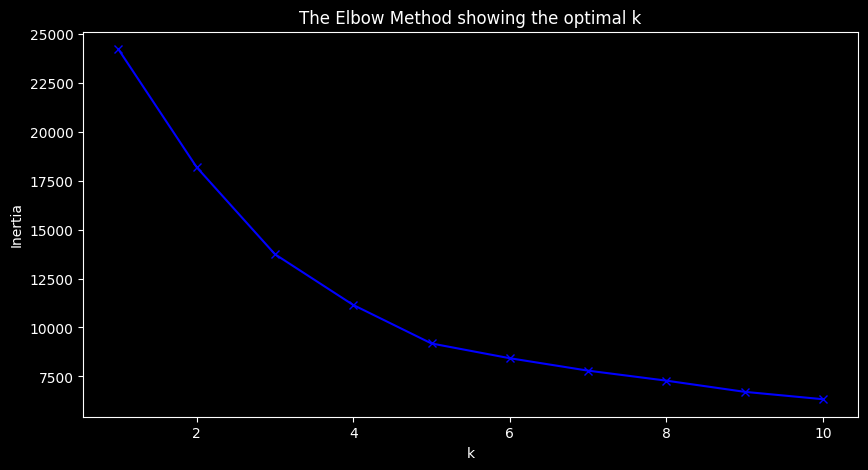

In [21]:
inertia = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++',
                        n_init=10,
                        random_state=42)
    kmeanModel.fit(combined_features)
    inertia.append(kmeanModel.inertia_)


plt.figure(figsize=(10,5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

'На глаз' видно, что оптимальным колличеством кластеров будет диапазон от 4 до 6

In [22]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(combined_features)

silhouette_avg = silhouette_score(combined_features, cluster_labels)
print(f"Средний Силуэтный коэффициент для {optimal_k} кластеров: {silhouette_avg}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Средний Силуэтный коэффициент для 4 кластеров: 0.4225454353350697


Среднее значение силуэта 0.422 для четырех кластеров — это довольно хороший результат, который говорит о том,
что кластеры относительно хорошо отделены друг от друга.

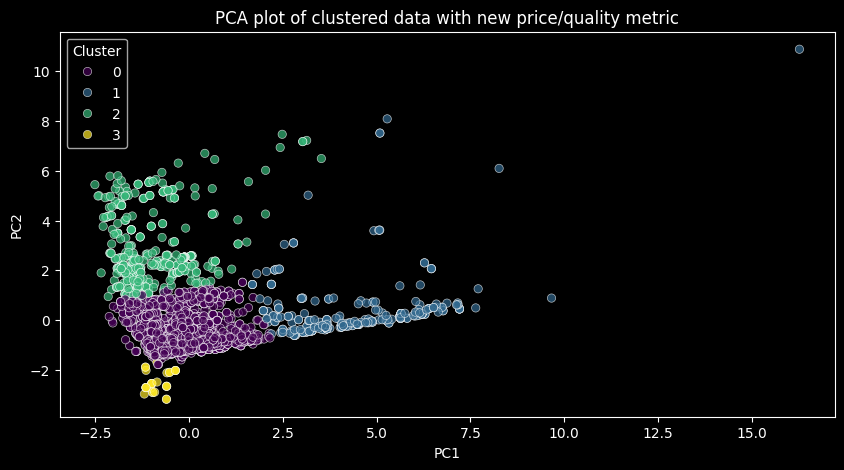

In [24]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 5))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA plot of clustered data with new price/quality metric')
plt.show()

 * Кластер 0 (фиолетовый): Элементы этого кластера сгруппированы ближе к началу координат, что может указывать на более низкие значения как цены, так и качества. Это может быть сегментом эконом-класса.

 * Кластер 1 (синий): Этот кластер расположен в центре графика и может включать телефоны среднего ценового сегмента с умеренными оценками качества.
 * Кластер 2 (зеленый): Этот кластер выделяется с наибольшим расстоянием по оси PC1, что может указывать на высокие значения цен и/или качества. Возможно, это премиум-сегмент.

 * Кластер 3 (желтый): Наименьший кластер, расположенный вдали от других, может представлять уникальные или нишевые товары с особыми характеристиками, которые отличают их от остальных сегментов.

# **Заключение**

Каждый кластер можно рассматривать как отдельный сегмент рынка с уникальными характеристиками,
что позволяет разрабатывать целевые стратегии для каждого из них.


 * Продвижение товаров эконом-класса может быть направлено на покупателей, ищущих бюджетные варианты.
 * Средний сегмент может быть целевой аудиторией для баланса между качеством и стоимостью.
 * Премиум-сегмент может быть предметом интереса для покупателей, готовых платить больше за высокое качество.
 * Нишевые или уникальные товары могут требовать более специализированных маркетинговых стратегий, направленных на определенную группу покупателей.